# Importing packages

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import logging

import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

from pathlib import Path
from typing import List, Tuple, Union
import lightning as L
import time 

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

In [31]:
import sys
sys.path.append('..')
sys.path.append('../data_modules/')

from data_modules.uci import *

In [32]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 22,
    'axes.linewidth': 2,
    'axes.titlesize': 24,
    'axes.edgecolor': 'black',
    'axes.labelsize': 24,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'font.family': 'Times New Roman',
    'legend.fontsize': 16,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Importing the Data That Will Train the Backbone


Here, we will import the data from two different repositories:

1. UCI - Human Activity Recognition with Smartphones: https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones
2. WISDM - 

# UCI dataset

The UCI dataset contains sensor signals of a triaxial accelerometer and gyroscope that were preprocessed and filtered. Then sliding windows of 2.56 seconds and 50% overlap were used to calculate statistical metrics of the window, thus, creating time series of these metrics. 

For our case, we use the original time series, where we have 128 readings per window. 

**Miscellaneous information:**

- Age bracket: 19-48 years
- Number of volunteers: 30 
- Activies being monitoring (labels): WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING
- Smartphone: Samsung Galaxy III
- Location: Waist
- Sampling rate: 50 Hz (data point each 0.02 seconds)
- Filters: 
- 1. For all sensors: Median filter + 3rd order low pass Butterworth Filter with cutoff of 20 Hz to remove noise. 
- 2. For accelerometers: Z component was low pass filtered with Butterwork with cutoff of 0.3 Hz to remove gravity

The sensors of this dataset are as follows:

- Triaxial acceleration from the accelerometer (total acceleration in the unit 'g'): Original time series (not used)
- Estimated body acceleration (in 'g'): Time series after subtracting the gravity from the total acceleration
- Triaxial Angular velocity from the gyroscope ('radians/second'). 


Note:

- 'g's (gravity of earth -> 9.80665 m/seg2).
- Features are normalized and bounded within [-1,1].

## Loading the dataset

In [33]:
base_path = '../data/uci/raw/'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

In [34]:
print(train_path)
print(test_path)

../data/uci/raw/train
../data/uci/raw/test


In [35]:
uci_train_dataframes = load_uci_dataset(train_path, 'train')
uci_test_dataframes = load_uci_dataset(test_path, 'test')

Loading UCI dataset from test folder: 100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


## Adding the Label to One of the Sensor Datasets

Since we will concatenate all the datasets, only one needs to have the label information

In [36]:
y_train = uci_train_dataframes[-1].drop(['SensorName','SubjectNumber','ExperimentNumber'],axis=1)
y_test = uci_test_dataframes[-1].drop(['SensorName','SubjectNumber','ExperimentNumber'],axis=1)
y_train.rename(columns={0: 'class'}, inplace=True)
y_test.rename(columns={0: 'class'}, inplace=True)

uci_train_dataframes[-2] = pd.concat([uci_train_dataframes[-2], y_train], axis=1)
uci_test_dataframes[-2] = pd.concat([uci_test_dataframes[-2], y_test], axis=1)

In [37]:
uci_train_dataframes_V2 = uci_train_dataframes[0:-1]
uci_test_dataframes_V2 = uci_test_dataframes[0:-1]

In [38]:
uci_train_dataframes_V2[0]

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,SensorName,SubjectNumber,ExperimentNumber
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576,body_acc_x,1,0
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599,body_acc_x,1,1
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178,body_acc_x,1,2
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028,body_acc_x,1,3
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328,body_acc_x,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.618763,0.774067,0.586568,0.217007,-0.027330,-0.171294,-0.218988,-0.137680,0.033094,...,-0.210942,-0.179295,-0.142085,-0.131831,-0.154000,-0.176886,-0.211068,body_acc_x,30,7347
7348,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,-0.066754,-0.042285,0.058089,0.106855,...,-0.326159,-0.379539,-0.382544,-0.371156,-0.295357,-0.203831,-0.124548,body_acc_x,30,7348
7349,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,0.096481,0.205834,0.441342,0.662930,...,-0.367070,-0.395135,-0.347338,-0.319902,-0.294935,-0.243403,-0.215215,body_acc_x,30,7349
7350,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,0.077571,0.253580,0.507805,0.583999,...,-0.413906,-0.379085,-0.356609,-0.317618,-0.315016,-0.330737,-0.272348,body_acc_x,30,7350


## Formatting the Dataset for the Dataloader

In [39]:
uci_train_dataframes_transf = transform_dataframes(uci_train_dataframes_V2)
uci_test_dataframes_transf = transform_dataframes(uci_test_dataframes_V2)

Transforming dataframes: 100%|██████████| 6/6 [00:00<00:00, 90.91it/s]


- Note that we have doubled the number of rows and decreased in half the number of columns
- Also note that we have 128 time steps and are using only 120 for the algorithm due to the constraints set by the dataloader

In [40]:
uci_train_dataframes_transf[5]

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,Set,SensorName,SubjectNumber,ExperimentNumber,class
0,0.022859,0.010316,0.013250,0.017751,0.002553,0.007725,0.004325,0.010617,0.017189,0.010511,...,0.004335,0.004312,0.006345,0.008526,0.008616,1,body_gyro_z,1,0,5
1,0.012268,0.016150,0.015895,0.012671,0.008774,0.005685,0.006093,0.008383,0.011140,0.012406,...,-0.006891,-0.004903,0.001354,0.008033,0.007355,1,body_gyro_z,1,1,5
2,0.002159,-0.000272,0.002631,0.003376,0.000057,0.001268,-0.001209,-0.002290,0.000451,-0.000389,...,0.018556,0.018173,0.018046,0.019393,0.018070,1,body_gyro_z,1,2,5
3,-0.000873,-0.005482,-0.004678,-0.000221,0.001588,0.009021,0.020953,0.028212,0.028609,0.024456,...,-0.002691,-0.000283,0.000404,-0.001556,-0.001239,1,body_gyro_z,1,3,5
4,-0.001574,0.000201,-0.000970,-0.000673,-0.000693,-0.002041,-0.000265,-0.000217,-0.001554,-0.000895,...,-0.011208,-0.013223,-0.013121,-0.012114,-0.009983,1,body_gyro_z,1,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14699,-0.232454,-0.117332,0.040190,0.224464,0.453560,0.670788,0.676179,0.495978,0.281462,0.096833,...,0.052284,0.116078,0.066480,0.033305,0.041621,2,body_gyro_z,30,7347,2
14700,0.061847,0.105364,0.192774,0.251018,0.300847,0.351178,0.272351,0.161631,0.092803,0.060685,...,0.092545,0.256139,0.287708,0.256055,0.227756,2,body_gyro_z,30,7348,2
14701,0.324083,0.319005,0.231496,0.234651,0.217504,0.158497,0.186879,0.192339,0.240986,0.281897,...,0.007684,0.158295,0.381402,0.433257,0.299354,2,body_gyro_z,30,7349,2
14702,0.201440,0.254344,0.281431,0.254206,0.227798,0.103476,-0.075655,-0.126216,-0.070250,0.039704,...,-0.007228,0.055853,0.075106,0.046540,-0.024443,2,body_gyro_z,30,7350,2


Removing all categorical columns except the SensorName so we can use this information for creating the dataset

In [41]:
uci_train_dataframes_transf_dropped = []
uci_test_dataframes_transf_dropped = []

for i in range(6):
    uci_train_dataframes_transf_dropped.append(uci_train_dataframes_transf[i].drop(['SubjectNumber','ExperimentNumber','Set'],axis=1).reset_index(drop=True))
    uci_test_dataframes_transf_dropped.append(uci_test_dataframes_transf[i].drop(['SubjectNumber','ExperimentNumber','Set'],axis=1).reset_index(drop=True))

In [42]:
uci_train_dataframes_transf_dropped[0]

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,SensorName
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.004399,0.002702,0.000345,0.002917,0.004979,0.003447,0.004378,0.005006,0.001997,body_acc_x
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000636,0.001047,0.003019,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,body_acc_x
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.002166,0.000422,0.000854,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,body_acc_x
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000552,0.001286,-0.000926,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,body_acc_x
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,-0.001230,-0.001129,-0.001334,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,body_acc_x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14699,-0.083267,-0.061474,-0.001786,0.324738,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,...,0.059454,-0.051592,-0.085863,-0.085427,-0.125762,-0.157137,-0.176316,-0.227949,-0.247119,body_acc_x
14700,-0.131831,-0.154000,-0.176886,-0.211068,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,...,0.055079,-0.010835,-0.085869,-0.073925,-0.050178,-0.067900,-0.177644,-0.311864,-0.316281,body_acc_x
14701,-0.371156,-0.295357,-0.203831,-0.124548,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,...,0.143526,0.125872,0.033159,-0.091123,-0.083596,-0.099131,-0.152359,-0.177051,-0.248426,body_acc_x
14702,-0.319902,-0.294935,-0.243403,-0.215215,-0.194471,-0.173802,-0.127545,-0.108369,-0.121152,-0.074004,...,0.214605,0.121716,0.071293,0.007803,-0.048764,-0.026929,-0.089308,-0.240819,-0.330930,body_acc_x


In [43]:
uci_train_renamed_dataframes = rename_columns(uci_train_dataframes_transf_dropped)
uci_test_renamed_dataframes = rename_columns(uci_test_dataframes_transf_dropped)

Renaming columns: 100%|██████████| 6/6 [00:00<00:00, 187.45it/s]


Renaming columns: 100%|██████████| 6/6 [00:00<00:00, 176.47it/s]


In [44]:
uci_train_renamed_dataframes[5]

,body_gyro_z_0,body_gyro_z_1,body_gyro_z_2,body_gyro_z_3,body_gyro_z_4,body_gyro_z_5,body_gyro_z_6,body_gyro_z_7,body_gyro_z_8,body_gyro_z_9,...,body_gyro_z_51,body_gyro_z_52,body_gyro_z_53,body_gyro_z_54,body_gyro_z_55,body_gyro_z_56,body_gyro_z_57,body_gyro_z_58,body_gyro_z_59,class
0,0.022859,0.010316,0.013250,0.017751,0.002553,0.007725,0.004325,0.010617,0.017189,0.010511,...,0.020997,0.020945,0.018400,0.010988,0.004335,0.004312,0.006345,0.008526,0.008616,5
1,0.012268,0.016150,0.015895,0.012671,0.008774,0.005685,0.006093,0.008383,0.011140,0.012406,...,0.006273,0.005763,-0.000024,-0.006042,-0.006891,-0.004903,0.001354,0.008033,0.007355,5
2,0.002159,-0.000272,0.002631,0.003376,0.000057,0.001268,-0.001209,-0.002290,0.000451,-0.000389,...,0.020503,0.025133,0.020913,0.016544,0.018556,0.018173,0.018046,0.019393,0.018070,5
3,-0.000873,-0.005482,-0.004678,-0.000221,0.001588,0.009021,0.020953,0.028212,0.028609,0.024456,...,-0.002383,-0.003674,-0.004933,-0.003351,-0.002691,-0.000283,0.000404,-0.001556,-0.001239,5
4,-0.001574,0.000201,-0.000970,-0.000673,-0.000693,-0.002041,-0.000265,-0.000217,-0.001554,-0.000895,...,-0.002969,-0.005610,-0.008606,-0.009409,-0.011208,-0.013223,-0.013121,-0.012114,-0.009983,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14699,-0.232454,-0.117332,0.040190,0.224464,0.453560,0.670788,0.676179,0.495978,0.281462,0.096833,...,-0.099035,-0.220565,-0.248863,-0.106949,0.052284,0.116078,0.066480,0.033305,0.041621,2
14700,0.061847,0.105364,0.192774,0.251018,0.300847,0.351178,0.272351,0.161631,0.092803,0.060685,...,0.101082,-0.078943,-0.135885,-0.083914,0.092545,0.256139,0.287708,0.256055,0.227756,2
14701,0.324083,0.319005,0.231496,0.234651,0.217504,0.158497,0.186879,0.192339,0.240986,0.281897,...,0.483397,0.370692,0.159151,0.009884,0.007684,0.158295,0.381402,0.433257,0.299354,2
14702,0.201440,0.254344,0.281431,0.254206,0.227798,0.103476,-0.075655,-0.126216,-0.070250,0.039704,...,0.340532,0.189904,0.031939,-0.021397,-0.007228,0.055853,0.075106,0.046540,-0.024443,2


## Concatenating All Sensor Datasets To Obtain the Final Dataset

In [45]:
uci_train_preprocessed = pd.concat(uci_train_renamed_dataframes, axis=1)
uci_test_preprocessed = pd.concat(uci_test_renamed_dataframes, axis=1)

In [46]:
uci_train_preprocessed.columns[120:190]

Index(['body_acc_z_0', 'body_acc_z_1', 'body_acc_z_2', 'body_acc_z_3',
       'body_acc_z_4', 'body_acc_z_5', 'body_acc_z_6', 'body_acc_z_7',
       'body_acc_z_8', 'body_acc_z_9', 'body_acc_z_10', 'body_acc_z_11',
       'body_acc_z_12', 'body_acc_z_13', 'body_acc_z_14', 'body_acc_z_15',
       'body_acc_z_16', 'body_acc_z_17', 'body_acc_z_18', 'body_acc_z_19',
       'body_acc_z_20', 'body_acc_z_21', 'body_acc_z_22', 'body_acc_z_23',
       'body_acc_z_24', 'body_acc_z_25', 'body_acc_z_26', 'body_acc_z_27',
       'body_acc_z_28', 'body_acc_z_29', 'body_acc_z_30', 'body_acc_z_31',
       'body_acc_z_32', 'body_acc_z_33', 'body_acc_z_34', 'body_acc_z_35',
       'body_acc_z_36', 'body_acc_z_37', 'body_acc_z_38', 'body_acc_z_39',
       'body_acc_z_40', 'body_acc_z_41', 'body_acc_z_42', 'body_acc_z_43',
       'body_acc_z_44', 'body_acc_z_45', 'body_acc_z_46', 'body_acc_z_47',
       'body_acc_z_48', 'body_acc_z_49', 'body_acc_z_50', 'body_acc_z_51',
       'body_acc_z_52', 'body_acc_z

In [47]:
new_column_names_uci = {'body_acc_x': 'accel-x',
                        'body_acc_y': 'accel-y',
                        'body_acc_z': 'accel-z',
                        'body_gyro_x': 'gyro-x',
                        'body_gyro_y': 'gyro-y',
                        'body_gyro_z': 'gyro-z'}

uci_train_standardized = standardize_columns(uci_train_preprocessed, new_column_names_uci)
uci_test_standardized = standardize_columns(uci_test_preprocessed, new_column_names_uci)

label_mapping = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

## Creating Training, Validation and Test Datasets

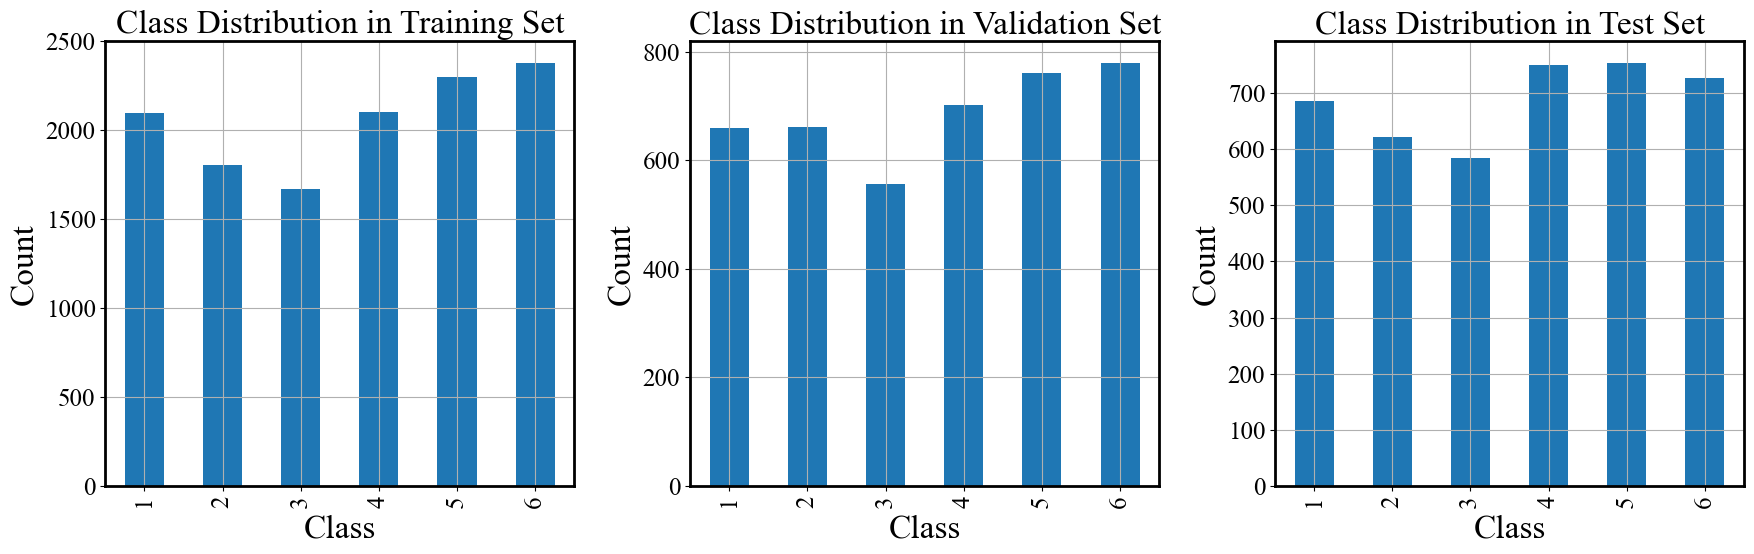

In [48]:
# Combine the datasets
uci_df = pd.concat([uci_train_standardized, uci_test_standardized], ignore_index=True)

# Split into training + validation and test sets
uci_train_df, uci_test_df = train_test_split(uci_df, test_size=0.2, random_state=0, shuffle=True) # 80-20 split

# Split training + validation into training and validation sets
uci_train_df, uci_validation_df = train_test_split(uci_train_df, test_size=0.25, shuffle=True, random_state=0) # 60-20 split

# Plot the class distribution
plot_class_distribution(uci_train_df, uci_validation_df, uci_test_df) 

In [49]:
uci_train_df

,accel-x_0,accel-x_1,accel-x_2,accel-x_3,accel-x_4,accel-x_5,accel-x_6,accel-x_7,accel-x_8,accel-x_9,...,gyro-z_51,gyro-z_52,gyro-z_53,gyro-z_54,gyro-z_55,gyro-z_56,gyro-z_57,gyro-z_58,gyro-z_59,class
3963,-0.070044,0.265961,0.219028,0.155993,0.368041,0.390953,0.233670,0.201223,0.183427,0.084496,...,1.341614,1.261310,0.876450,0.524371,0.110000,0.095540,0.379624,0.390101,0.254366,2
5000,-0.274033,-0.293285,-0.180987,-0.077954,0.080231,0.358899,0.725620,0.791722,0.462264,0.237741,...,0.475894,0.450368,0.393600,0.210740,0.159339,0.199261,0.128737,0.104654,0.100500,1
182,0.001056,-0.001669,-0.004399,-0.000110,0.008120,0.010487,0.000799,-0.012978,-0.011753,-0.000795,...,0.003856,0.003705,0.002865,0.002310,0.000550,0.000148,-0.000896,0.000311,0.001732,5
8995,0.003356,0.003055,0.002161,0.001380,0.001715,0.000815,0.000078,0.000276,0.000464,0.000344,...,-0.000968,0.001343,0.000785,0.006727,0.010595,0.005379,-0.000704,-0.001053,-0.001126,5
19622,-0.088983,-0.115429,-0.142683,-0.147781,-0.151559,-0.156931,-0.159907,-0.143514,-0.127286,-0.119956,...,0.127677,0.052608,0.010786,0.000124,-0.010824,-0.093580,-0.125322,-0.073962,-0.019748,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19546,-0.000906,-0.002164,0.001022,0.005053,0.002740,0.001015,0.000485,0.000745,0.003617,0.004975,...,-0.000612,-0.002575,-0.003566,-0.000870,0.003357,0.002379,-0.001001,0.000471,0.001824,4
18611,0.003209,0.001642,-0.000853,-0.001329,-0.001619,-0.001911,0.000018,0.001721,0.003186,0.003828,...,-0.003372,-0.001402,0.004211,0.002992,0.000198,0.001411,0.000458,0.000795,0.000915,6
18909,0.018369,-0.001738,-0.020992,-0.021434,-0.011372,-0.005912,-0.006707,-0.006282,-0.006785,-0.008179,...,0.068964,0.071019,0.065561,0.056436,0.048212,0.046220,0.047705,0.044564,0.040351,6
17720,0.014328,0.011649,0.008016,0.010483,0.014493,0.012325,0.013020,0.016020,0.014271,0.014645,...,-0.023497,-0.024743,-0.027935,-0.028407,-0.026196,-0.023995,-0.025922,-0.028587,-0.028322,6


## Saving the Final Preprocessed UCI dataset

In [50]:
output_dir = '../data/uci/preprocessed/'

# uci_train_df.to_csv(output_dir + 'train.csv', index=False)

uci_train_df.to_parquet(output_dir + 'train.parquet', index=False)
uci_validation_df.to_parquet(output_dir + 'validation.parquet', index=False)
uci_test_df.to_parquet(output_dir + 'test.parquet', index=False)

print("Datasets have been split and saved successfully!")

Datasets have been split and saved successfully!


# WISDM Dataset

# UCI Data Module

In [51]:
logging.basicConfig(level=logging.DEBUG)

In [59]:
uci_data_module = UCIDataModule(root_data_dir='../data/uci/preprocessed/',
                           batch_size=32,
                           flatten=False,
                           target_column='class')

train_uci_dl = uci_data_module.train_dataloader()
val_uci_dl = uci_data_module.val_dataloader()

DEBUG:root:Loading data from Parquet file
DEBUG:root:Loading data from Parquet file


In [53]:
loader_iter = iter(val_uci_dl)

In [54]:
first_batch = next(iter(train_uci_dl))
print("type(first_batch) =", type(first_batch))
print("len(first_batch) =", len(first_batch))

type(first_batch) = <class 'list'>
len(first_batch) = 2


In [55]:
element1 = first_batch[0] # First element
element2 = first_batch[1] # second element

print("element1.shape =", element1.shape)
print("element2.shape =", element2.shape)

element1.shape = torch.Size([32, 6, 60])
element2.shape = torch.Size([32])


In [56]:
X_1 = element1[0] # Features
y_1 = element2[0] # Labels

print("y1: ", y_1)
print("X1: ", X_1)

y1:  tensor(1)
X1:  tensor([[-9.0626e-02, -1.7159e-01, -1.2898e-01, -9.2208e-02, -1.4704e-01,
         -2.6566e-01, -2.9187e-01, -3.4494e-01, -3.9586e-01, -3.6629e-01,
         -3.6659e-01, -2.8358e-01, -1.6666e-01, -7.8910e-02, -1.6234e-02,
          7.2148e-02,  3.1318e-01,  3.7742e-01,  3.1402e-01,  3.9501e-01,
          3.0532e-01,  1.5612e-01,  1.0792e-01, -8.1816e-02, -1.5029e-01,
          1.4266e-01,  4.1581e-01,  4.0380e-01,  2.5218e-01,  1.0153e-02,
         -2.5360e-01, -2.9736e-01, -3.4323e-01, -5.2204e-01, -4.6626e-01,
         -4.0633e-01, -4.5466e-01, -2.4627e-01, -4.5353e-02,  9.5985e-02,
          2.3833e-01,  1.5670e-01,  1.4861e-01,  1.9013e-01,  1.1147e-01,
          1.7638e-01,  4.1133e-01,  5.5458e-01,  9.0740e-02, -5.3435e-01,
         -3.8237e-01, -1.3803e-01, -1.8915e-01, -1.8974e-02, -4.1734e-02,
         -2.2277e-01, -2.2906e-01, -3.9941e-01, -4.4798e-01, -2.9250e-01],
        [-2.3849e-01, -2.2033e-01, -1.3454e-01, -5.5583e-03, -4.9502e-02,
         -4.6481e

Note that I 0 indexed the data so that i could train my TF_C model

In [57]:
element2

tensor([1, 2, 4, 3, 4, 5, 5, 5, 3, 0, 3, 4, 0, 3, 3, 5, 4, 5, 2, 0, 4, 5, 0, 2,
        5, 1, 0, 3, 4, 0, 0, 1])

In [58]:
X_1_np = X_1.cpu().numpy().reshape(6,60)
print("X_1_np.shape =", X_1_np.shape)

X_1_np.shape = (6, 60)


# WISDM Data Module

# References:

- https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf 
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones 